In [1]:
import numpy as np

import scipy
import scipy.io as scio
import scipy.signal as signal
from scipy import ndimage, misc
from scipy.ndimage import median_filter
from scipy.signal import hilbert

# Frequency filtering by A-scan
from scipy.signal import butter, lfilter, hilbert, firwin, decimate, resample
from scipy import interpolate

import imageio as io

from skimage import exposure
from skimage import feature

import sys
import os, fnmatch
import struct

#import itk
#from itkwidgets import view
#import ipywidgets as ipyw
#import ipyvolume as ipv

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from PIL import Image

import math
import itertools
import gc

In [2]:

def resize_data(data,new_size_x,new_size_y,new_size_z):
    initial_size_x = data.shape[0]
    initial_size_y = data.shape[1]
    initial_size_z = data.shape[2]

    delta_x = initial_size_x / new_size_x
    delta_y = initial_size_y / new_size_y
    delta_z = initial_size_z / new_size_z

    new_data = np.zeros((new_size_x, new_size_y, new_size_z))

    for x, y, z in itertools.product(range(new_size_x),
                                     range(new_size_y),
                                     range(new_size_z)):
        new_data[x][y][z] = data[int(x * delta_x)][int(y * delta_y)][int(z * delta_z)]

    return new_data

In [3]:
def interp2d_interleave(z,n):
    '''performs linear interpolation on a grid

    all points are interpolated in one step not recursively

    Parameters
    ----------
    z : 2d array (M,N)
    n : int
    number of points interpolated

    Returns
    -------
    zi : 2d array ((M-1)*n+M, (N-1)*n+N)
        original and linear interpolated values

    '''
    frac = np.atleast_2d(np.arange(0,n+1)/(1.0+n)).T
    zi1 = np.kron(z[:,:-1],np.ones(len(frac))) + np.kron(np.diff(z),frac.T)
    zi1 = np.hstack((zi1,z[:,-1:]))
    zi2 = np.kron(zi1.T[:,:-1],np.ones(len(frac))) + np.kron(np.diff(zi1.T),frac.T)
    zi2 = np.hstack((zi2,zi1.T[:,-1:]))
    return zi2.T

def interp2d_interleave_recursive(z,n):
    '''interpolates by recursively interleaving n times
    '''
    zi = z.copy()
    for ii in range(1,n+1):
        zi = interp2d_interleave(zi,1)
    return zi

In [4]:
def norm(arr_):
    norm_arr= (arr_ - np.min(arr_)) / (np.max(arr_) - np.min(arr_))
    return norm_arr

In [5]:
def flip180(arr):
    new_arr = arr.reshape(arr.size)
    new_arr = new_arr[::-1]
    new_arr = new_arr.reshape(arr.shape)
    return new_arr

In [6]:
def map_ax(vol_arr,axx):
    map_xy = np.ndarray.max(vol_arr, axx)
    return map_xy

In [7]:
def depth_ax(arr_,axx):
    return np.argmax(arr_, axis=axx)

In [8]:
def plot_vol(load_path,cut_left,cut_right, threshold_bottom, threshold_top):
    f = open(load_path,"rb")
    size_of_data = np.fromfile(f, dtype=">I", count = 3)
    y_axis = size_of_data[0]
    x_axis = size_of_data[1]
    z_axis = size_of_data[2]

    raw_data = np.fromfile(f, dtype=">H", count = -1)

    f.close()
    #data = np.reshape(raw_data,(z_axis, x_axis, y_axis))
    data = np.reshape(raw_data,(y_axis, x_axis, z_axis))
    re_data = np.zeros(data.shape)
    print(np.shape(re_data))
    for i in range(y_axis):
        #re_data[:,:,i] = np.subtract(np.double(data[:,:,i]),np.double(np.mean(data[:,:,i])))
        re_data[i,:,:] = np.subtract(np.double(data[i,:,:]),np.double(np.mean(data[i,:,:])))
        #re_data[:,:,i] = abs(hilbert(re_data[:,:,i]))
        re_data[i,:,:] = abs(hilbert(re_data[i,:,:]))
            
    vol_t = re_data[4:,cut_left:-cut_right,:1000]
    vol_t = np.where(vol_t> threshold_top, threshold_top, vol_t)
    #b_scan_path = bin_path + "image/"
    #for k in range(y_axis):
    #    file_name = b_scan_path+"image_" +str(k) + ".jpg"
    #    imageio = io.imwrite(file_name, re_data[k,:,:])
    return vol_t

In [9]:
def strech_1D(org_arr, tgt_arr):
    f = interpolate.interp1d(np.arange(0, len(org_arr)), org_arr)
    str_f = f(np.linspace(0.0, len(org_arr)-1, len(tgt_arr)))
    return str_f

In [10]:
def bandpass_vol(arr_3D, lowcut, highcut):
    filt_3D = np.zeros(np.shape(arr_3D))
    for x_pos in range(np.shape(arr_3D)[0]):
        for y_pos in range(np.shape(arr_3D)[1]):
            a_scan = arr_3D[x_pos,y_pos,:]
            #filt_3D[x_pos,y_pos, :] = np.abs(hilbert(butter_bandpass_filter(a_scan, lowcut, highcut, fs, order=3)))
            tmpScanline1 = np.squeeze(a_scan)
            tmpScanline = tmpScanline1 - np.mean(tmpScanline1)
            tmpScanline = decimate(tmpScanline, deci_factor)
            filt_3D[x_pos,y_pos,:] = strech_1D(np.abs(hilbert(np.convolve(tmpScanline, bpf_coef, 'same'))),a_scan)
    return filt_3D

In [11]:
def makesurf(arr_3D):
    ## Auto shift each A-scan to surface (20%) [x,y,Z]
    temp_3D = np.zeros(np.shape(arr_3D))
    depth_loc = np.zeros((np.shape(arr_3D)[0],np.shape(arr_3D)[1]))
    for i in range(np.shape(arr_3D)[0]):
        for j in range(np.shape(arr_3D)[1]):
            pos = -(np.where(arr_3D[i,j,:] == np.amax(arr_3D[i,j,:]))[0][0])-int(np.shape(arr_3D)[2]/2)
            depth_loc[i,j] = pos
            temp_3D[i,j,:] =  np.roll(arr_3D[i,j,:],pos)
    return temp_3D, depth_loc

In [12]:
def crop_by_ax_pix2pix(vol_temp1, vol_temp2, dir_, type_of_sp, name_of_sp, num_of_st,ax):
    vol_temp1 = (norm(vol_temp1)*(255)).astype(np.uint8)
    vol_temp2 = (norm(vol_temp2)*(255)).astype(np.uint8)
    if   ax=='xz':
        sideid = 1 
        sideid_r = 0
    elif ax=='yz':
        sideid = 0
        sideid_r = 1
    else:
        sideid = -1
        sideid_r = -1
    root = dir_+ type_of_sp
    sample = name_of_sp+ax
    types = type_of_sp

    step = int(np.shape(vol_temp1)[sideid_r]/num_of_st)
    print(np.shape(vol_temp1)[sideid_r])
    for numID in range(num_of_st):
        for sliceID in range(np.shape(vol_temp1)[sideid]):
            if   sideid == 0:
                b_scan1 = np.rot90(vol_temp1[sliceID,(numID*step):((numID+1)*step),:],3)
                b_scan2 = np.rot90(vol_temp2[sliceID,(numID*step):((numID+1)*step),:],3)
            elif sideid == 1:
                b_scan1 = np.rot90(vol_temp1[(numID*step):((numID+1)*step),sliceID,:],3)
                b_scan2 = np.rot90(vol_temp2[(numID*step):((numID+1)*step),sliceID,:],3)
            im_AB = Image.fromarray(np.concatenate([b_scan1, b_scan2], 1))
            name = root + "/" + sample + "_" + types +'-'+str(numID)+'-'+str(sliceID)+'.jpg'
            im_AB.save(name)
            
def crop_by_ax_cyclegan(vol_temp, dir_, type_of_sp, name_of_sp, num_of_st,ax):
    vol_temp = (norm(vol_temp)*(255)).astype(np.uint8)
    print(np.shape(vol_temp))
    if   ax=='yz':
        sideid = 1 
        sideid_r = 0
    elif ax=='xz':
        sideid = 0
        sideid_r = 1
    else:
        sideid = -1
        sideid_r = -1
    root = dir_+ type_of_sp
    sample = name_of_sp+ax
    types = type_of_sp

    step = int(np.shape(vol_temp)[sideid_r]/num_of_st)
    for numID in range(num_of_st):
        for sliceID in range(np.shape(vol_temp)[sideid]):
            if   sideid == 0:
                b_scan = np.rot90(vol_temp[sliceID,int(numID*step):int((numID+1)*step),:],3)
            elif sideid == 1:
                b_scan = np.rot90(vol_temp[int(numID*step):int((numID+1)*step),sliceID,:],3)
            img1 = Image.fromarray(median_filter(b_scan,3))
            name1 = root + "/" + sample + "_" + types +'-'+str(numID)+'-'+str(sliceID)+'.jpg'
            img1.save(name1)

In [13]:
def re_surf(arr_3D, map_):
    ## Auto shift each A-scan to surface (20%) [x,y,Z]
    temp_3D = np.zeros(np.shape(arr_3D))
    for i in range(np.shape(arr_3D)[0]):
        for j in range(np.shape(arr_3D)[2]):
            pos = -(map_[i,j])
            temp_3D[i,:,j] =  np.roll(arr_3D[i,:,j],pos)
    return temp_3D

In [14]:
fs = 5000.0
lowcut = 200.0 
highcut = 2300

fs_old = 1e9
fs = 200e6
deci_factor = int(fs_old/fs)

bpf_coef = firwin(64, [10e6/(fs/2), 60e6/(fs/2)], pass_zero='bandpass')
#bpf_coef = fir1(64, [40e6 60e6]/(fs/2), 'bandpass');
#bpf_coef = fir1(64, [20e6 30e6]/(fs/2), 'bandpass');

In [15]:
### Modify gist colormap
gist = cm.get_cmap('gist_ncar', 256) #gist_ncar
newcolors1 = gist(np.linspace(0, 1, 256))
newcolors2 = gist(np.linspace(0, 1, 256))
black = np.array([1/256, 1/256, 1/256, 1])
newcolors1[:2,:] = black
newgist_blockbottom = ListedColormap(newcolors1) #newgist_blockbottom is colormap with black background
newcolors2[:2,:] = black
newcolors2[253:,:] = black
newgist_block2head = ListedColormap(newcolors2) #newgist_block2head is colormap with black background & black top

### Modify Jet colormap
jet = cm.get_cmap('jet', 256) #gist_ncar
newcolors1 = jet(np.linspace(0, 1, 256))
newcolors2 = jet(np.linspace(0, 1, 256))
black = np.array([1/256, 1/256, 1/256, 1])
newcolors1[:2,:] = black
newjet_blockbottom = ListedColormap(newcolors1) #newgist_blockbottom is colormap with black background
newcolors2[:2,:] = black
newcolors2[254:,:] = black
newjet_block2head = ListedColormap(newcolors2) #newgist_block2head is colormap with black background & black top


## Edit inside this box
x_size = 1.5
y_size = 15
ftsize = 10
depth = 2
kernel = 1

sample_n = "ear"
sample_t = "or"

bin_path = "./raw/"+sample_n+"/"+sample_t+"/"
#bin_path = "../AR-PAM-data/AR-OR-leaf/OR-bihleaf-02/bin/"
#bin_path = "../AR-PAM-data/AR-OR-leaf/20191226-ARPAMdata/combine/AR-PAM-ref04/bin/"
#bin_path = "../AR-PAM-data/AR-OR-leaf/20191226-ARPAMdata/combine/OR-PAM-ref03/bin/"
#bin_path = "../OR-PAM-data/PhantomData/20210827-phantomPAM/test-OR/bin/"
#bin_path = "../OR-PAM-data/PhantomData/20210915-phantom3/test-AR/bin/"
ls = sorted(os.listdir(bin_path))
num = np.shape(ls)
print(ls)

['OR-PAM-ref03_0.bin', 'OR-PAM-ref03_1.bin', 'OR-PAM-ref03_2.bin', 'OR-PAM-ref03_3.bin', 'OR-PAM-ref03_4.bin', 'OR-PAM-ref03_5.bin', 'OR-PAM-ref03_6.bin', 'OR-PAM-ref03_7.bin']


In [16]:
vol = np.zeros((296, 1, 1000)) #496 - 512 - leaf  / 296 - 1000 - ear / 
for slideID in ls:
    vol_t = plot_vol(bin_path + slideID, 60, 240, 0, 4000) # 60 -240
    vol = np.concatenate((vol, vol_t), axis=1)
temp_vol, surf_or = makesurf(vol)
new_vol = temp_vol[:,:,300:700]

(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)


In [17]:
## Only Hair Phantom
#vol_t1 = plot_vol(bin_path+ls[0], 50, 45, 500, 4000) #50-45
#vol_t2 = plot_vol(bin_path+ls[1], 50, 45, 500, 4000) #50-45
#vol_t3 = plot_vol(bin_path+ls[2], 50, 45, 500, 4000) #50-45
#vol_t4 = plot_vol(bin_path+ls[3], 50, 45, 500, 4000) #50-45
#vol_t5 = plot_vol(bin_path+ls[4], 50, 45, 500, 4000) #50-45
#vol = np.concatenate((np.roll(np.flip(vol_t1, axis=0), 100, 2), np.roll(vol_t2, 50, 2), np.flip(vol_t3, axis=0), np.roll(vol_t4, -20, 2), np.roll(np.flip(vol_t5, axis=0), -50, 2)), axis=1)

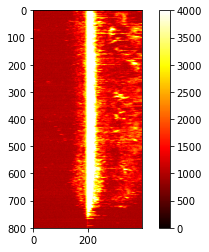

In [18]:
plt.imshow(map_ax(new_vol[:,:,:],0),cmap="hot", vmin=0)
plt.colorbar()
plt.show()

In [19]:
new_vol = resize_data(new_vol,1024,1024,256) ## Sample (1000,1000,1000) - hair (500,500,1000)
del vol 
gc.collect()

5956

In [20]:
#flt_vol_or = bandpass_vol(new_vol, lowcut,highcut)
flt_vol_or = new_vol
del new_vol 
gc.collect()

0

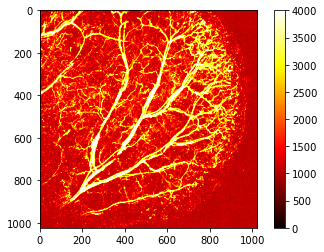

In [21]:
map_or = map_ax(flt_vol_or,2)
plt.imshow(map_or,cmap="hot", vmin=0)
plt.colorbar()

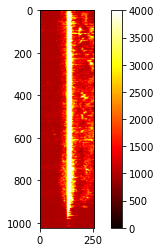

In [22]:
plt.imshow(map_ax(flt_vol_or,0),cmap="hot", vmin=0)
plt.colorbar()

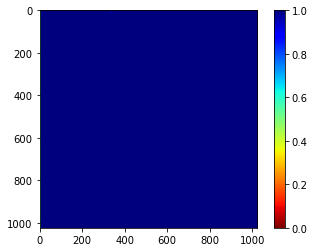

In [23]:
plt.imshow(norm(depth_ax(flt_vol_or,2)),cmap="jet_r")
plt.colorbar()

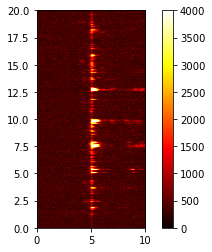

In [24]:
plt.imshow(flt_vol_or[400,:,:],cmap="hot", vmin=0 , vmax =4000,extent=[0,10,0,20])
plt.colorbar()

In [25]:
fs = 5000.0
lowcut = 200.0 
highcut = 2300

fs_old = 1e9
fs = 200e6
deci_factor = int(fs_old/fs)

bpf_coef = firwin(64, [40e6/(fs/2), 90e6/(fs/2)], pass_zero='bandpass')
#bpf_coef = fir1(64, [40e6 60e6]/(fs/2), 'bandpass');
#bpf_coef = fir1(64, [20e6 30e6]/(fs/2), 'bandpass');

In [26]:
sample_n = "ear"
sample_t = "ar"

bin_path = "./raw/"+sample_n+"/"+sample_t+"/"
#bin_path = "../AR-PAM-data/AR-OR-leaf/OR-bihleaf-02/bin/"
#bin_path = "../AR-PAM-data/AR-OR-leaf/20191226-ARPAMdata/combine/AR-PAM-ref04/bin/"
#bin_path = "../AR-PAM-data/AR-OR-leaf/20191226-ARPAMdata/combine/OR-PAM-ref03/bin/"
#bin_path = "../OR-PAM-data/PhantomData/20210827-phantomPAM/test-OR/bin/"
#bin_path = "../OR-PAM-data/PhantomData/20210915-phantom3/test-AR/bin/"
ls = sorted(os.listdir(bin_path))
num = np.shape(ls)
print(ls)

vol = np.zeros((296, 1, 1000)) #496 - 512 - leaf  / 296 - 1000 - ear / 
for slideID in ls:
    vol_t = plot_vol(bin_path + slideID, 60, 240, 0, 4000) # 60 -240
    vol = np.concatenate((vol, vol_t), axis=1)
temp_vol, surf_ar = makesurf(vol)
#temp_vol = vol
new_vol = temp_vol[:,:,300:700]
new_vol = resize_data(new_vol,1024,1024,256) ## Sample (1000,1000,1000) - hair (500,500,1000)
del vol 
gc.collect()
#flt_vol = bandpass_vol(new_vol, lowcut,highcut)
flt_vol = new_vol
del new_vol 
gc.collect()

['AR-PAM-ref04_0.bin', 'AR-PAM-ref04_1.bin', 'AR-PAM-ref04_2.bin', 'AR-PAM-ref04_3.bin', 'AR-PAM-ref04_4.bin', 'AR-PAM-ref04_5.bin', 'AR-PAM-ref04_6.bin', 'AR-PAM-ref04_7.bin']
(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)
(300, 400, 1024)


0

In [27]:
flt_vol_ar = flt_vol
del flt_vol 
gc.collect()

0

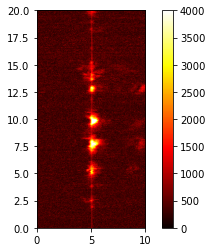

In [28]:
plt.imshow(flt_vol_ar[400,:,:],cmap="hot", vmin=0 , vmax =4000,extent=[0,10,0,20])
plt.colorbar()

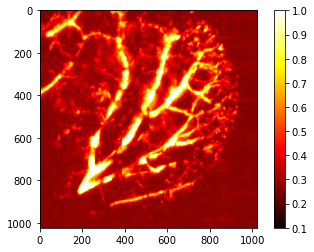

In [29]:
map_ar = norm(map_ax(flt_vol_ar,2))
plt.imshow(map_ar ,cmap="hot",vmin=0.1)
plt.colorbar()

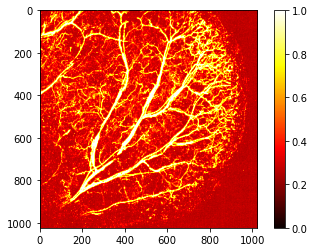

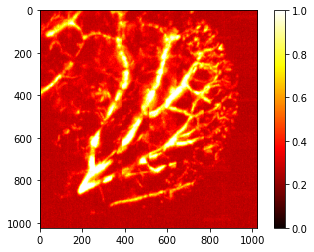

In [30]:
bin_ar_temp = np.where(norm(flt_vol_ar)>=0.15,flt_vol_ar,0)
bin_or_temp = np.where(norm(flt_vol_ar)>=0.15,flt_vol_or,0)
plt.imshow(norm(map_ax(bin_or_temp,2)),cmap="hot")
plt.colorbar()
plt.show()
plt.imshow(norm(map_ax(bin_ar_temp,2)),cmap="hot")
plt.colorbar()

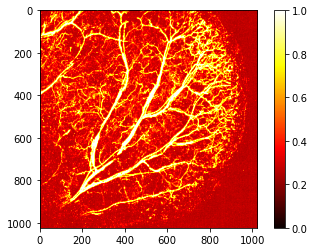

In [31]:
plt.imshow(norm(map_ax(flt_vol_or,2)),cmap="hot")
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(bin_ar_temp[:,500,:],cmap="hot")
plt.colorbar()
plt.show()
plt.imshow(bin_or_temp[:,500,:],cmap="hot")
plt.colorbar()
plt.show()
plt.imshow(flt_vol_or[:,500,:],cmap="hot")
plt.colorbar()
plt.show()